**КЛАСТЕРИЗАЦИЯ**

---



Ссылка на датасет - https://archive.ics.uci.edu/dataset/763/land+mines-1

Обнаружение мин, заложенных в землю

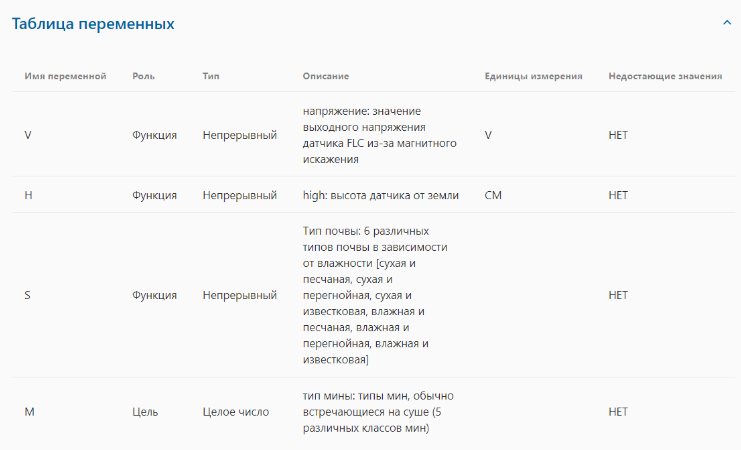

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import mpl_toolkits.mplot3d
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
# получение набора данных
data = fetch_ucirepo(id=763)
# Извлекаем признаки и целевые переменные
X = data.data.features
y = data.data.targets
y.columns = ['target']
# Объединяем X и y
df = pd.concat([X, y], axis=1)

**Анализ данных**

In [4]:
df.head()

,V,H,S,target
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V       338 non-null    float64
 1   H       338 non-null    float64
 2   S       338 non-null    float64
 3   target  338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 10.7 KB


In [6]:
vals = df["target"].unique()
vals

array([1, 2, 3, 4, 5])

In [7]:
# Выбираем признаки для кластеризации (кроме целевой переменной)
cols_for_clusters = df.columns[:-1]  # Исключаем столбец 'target'
cols_for_clusters

Index(['V', 'H', 'S'], dtype='object')

In [8]:
# Делаем копию исходного датасета
df_copy = df.copy()

In [9]:
# Убираем целевую переменную из набора данных
df_without_label = df_copy[cols_for_clusters].copy()

In [10]:
df_without_label.head(10)

,V,H,S
0,0.338157,0.000000,0.0
1,0.320241,0.181818,0.0
2,0.287009,0.272727,0.0
3,0.256284,0.454545,0.0
4,0.262840,0.545455,0.0
5,0.240966,0.727273,0.0
6,0.254410,0.818182,0.0
7,0.234924,1.000000,0.0
8,0.353474,0.000000,0.6
9,0.335347,0.181818,0.6


In [11]:
# Кодируем целевые метки
encoder = OrdinalEncoder()
df_copy[['target']] = encoder.fit_transform(df_copy[['target']])

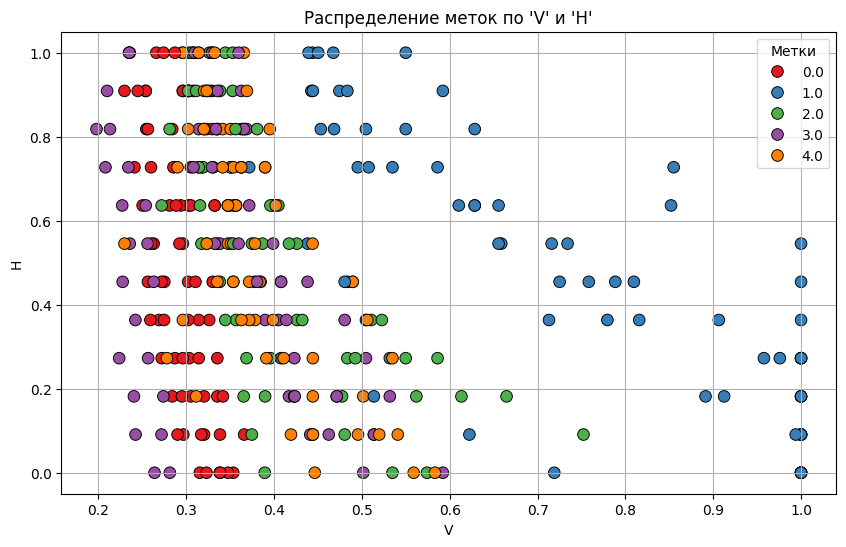

In [12]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_copy, x='V', y='H', hue='target', palette='Set1', s=70, edgecolor="k")

plt.title("Распределение меток по 'V' и 'H'")
plt.xlabel("V")
plt.ylabel("H")
plt.legend(title="Метки")
plt.grid(True)
plt.show()

***ВЫВОДЫ:***
* мины типа 1 обнаруживаются на большей высоте и дают более сильные напряжения
* все остальные метки сосредоточены в диапазоне V от 0.2 до 0.4 и более равномерно распределены по значению H


In [75]:
X = df_without_label
y = df_copy[['target']]

Функция для отрисовки результатов кластеризации и значением коэффициента силуэта для K-means

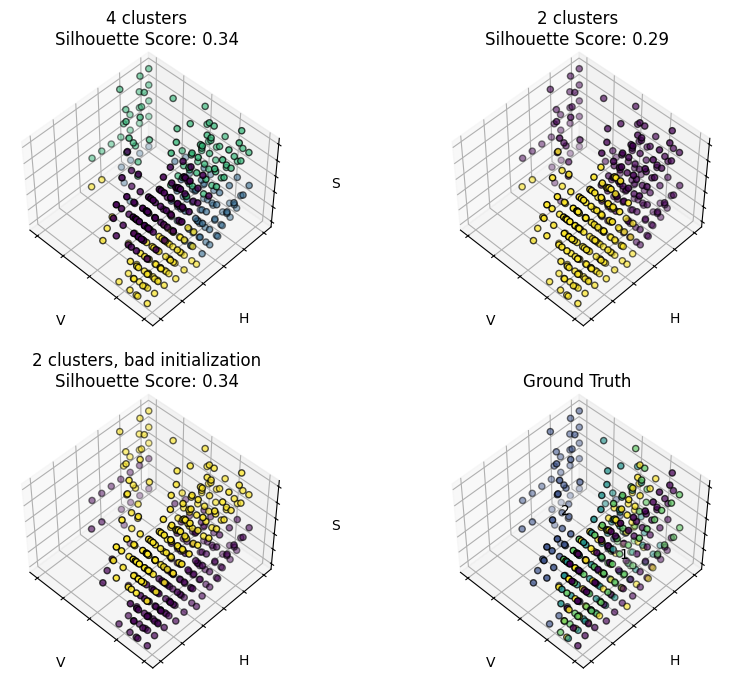

In [80]:
def plot_clusters_with_silhouette(X, y):
    estimators = [
        ("k_means_4", KMeans(n_clusters=4)),
        ("k_means_2", KMeans(n_clusters=2)),
        ("k_means_bad_init", KMeans(n_clusters=2, n_init=1, init="random")),
    ]

    fig = plt.figure(figsize=(10, 8))
    titles = ["4 clusters", "2 clusters", "2 clusters, bad initialization"]
    for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
        ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
        est.fit(X)
        labels = est.labels_

        # Оценка методом силуэта
        silhouette_avg = silhouette_score(X, labels)

        ax.scatter(X["V"], X["H"], X["S"], c=labels.astype(float), edgecolor="k")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        ax.set_xlabel("V")
        ax.set_ylabel("H")
        ax.set_zlabel("S")
        ax.set_title(f"{title}\nSilhouette Score: {silhouette_avg:.2f}")

    # Истинные метки
    ax = fig.add_subplot(2, 2, 4, projection="3d", elev=48, azim=134)

    for name, label in [(vals[0], 1), (vals[1], 0)]:
        ds = df[df["target"] == name]
        ax.text3D(
            ds["V"].mean(),
            ds["H"].mean(),
            ds["S"].mean(),
            name,
            horizontalalignment="center",
            bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
        )

    ax.scatter(X["V"], X["H"], X["S"], c=y, edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("V")
    ax.set_ylabel("H")
    ax.set_zlabel("S")
    ax.set_title("Ground Truth")

    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

plot_clusters_with_silhouette(X, y)

***ВЫВОДЫ:***

* **4 КЛАСТЕРА** - (Silhouette Score: 0.34): При разбиении данных на 4 кластера получен наивысший показатель силуэта (0.34) - лучшее разделение данных на кластеры по сравнению с другими конфигурациями.
* **2 КЛАСТЕРА** - (Silhouette Score: 0.29): Разбиение на 2 кластера показало более низкий Silhouette Score (0.29), что указывает на менее чёткое разделение данных.
* **2 КЛАСТЕРА, ПЛОХАЯ ИНИЦИАЛИЗАЦИЯ** (Silhouette Score: 0.34) - При плохой инициализации значение силуэта такое же, как и в варианте с 4 кластерами (0.34). Выбранные кластеры не сильно зависят от начальной инициализации, при неудачном выборе начальных центров качество кластеризации остаётся приблизительно таким же. Низкий показатель силуэта указывает на возможное смешение данных между кластерами.
* **РЕАЛЬНЫЕ МЕТКИ** (Ground Truth): На графике реальные метки данных, которые демонстрируют сложную и плотную структуру без чётко выраженных границ. => данные сложно разбить на кластеры на основе параметров V, H, и S.

*Низкие значения силуэта для всех вариантов разбиения указывают на слабую кластеризуемость данных по трём параметрам*

Функция для поиска наилучших значений метрик

[5, 0.36207934871939473, 0.04114615103067531, array([[0.36021411, 0.77597403, 0.79761905],
       [0.4423887 , 0.24484849, 0.17333333],
       [0.33641973, 0.77383592, 0.19512195],
       [0.4035391 , 0.24104683, 0.8       ],
       [0.89991115, 0.29325513, 0.69032258]])]


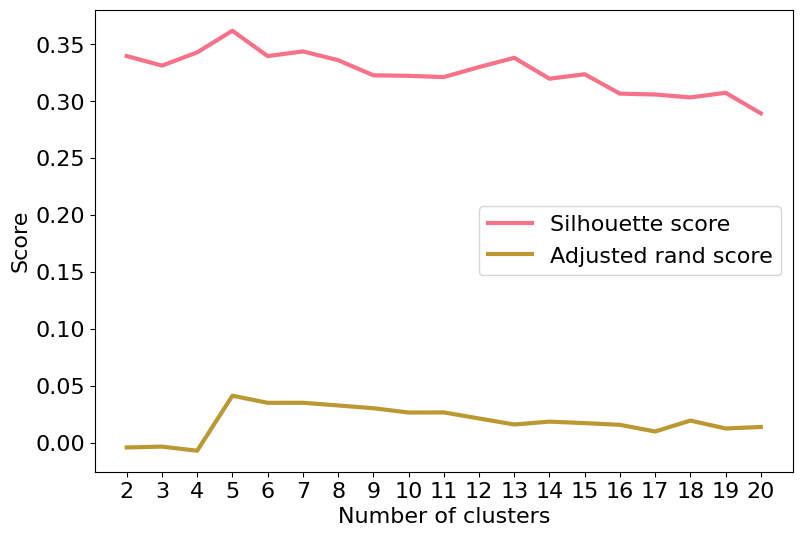

In [82]:
def plot_silhouette_ari(X, y):
    n_clusters = np.arange(2, 21)
    y_flat = y.values.flatten()
    best_metric = [0, 10000, 0, []]

    silhouette_score_values = []
    adjusted_rand_score_values = []

    for n in n_clusters:
        clusterer = KMeans(n_clusters=n, max_iter=300, n_init=30)
        clusterer.fit(X)
        y_pred = clusterer.predict(X)

        score1 = metrics.silhouette_score(X, y_pred)
        silhouette_score_values.append(score1)

        score2 = metrics.adjusted_rand_score(y_flat, y_pred)
        adjusted_rand_score_values.append(score2)

        if score1 < best_metric[1] and score2 > best_metric[2]:
            best_metric[1] = score1
            best_metric[2] = score2
            best_metric[3] = clusterer.cluster_centers_
            best_metric[0] = n

    print(best_metric)
    plt.figure(figsize=(9, 6))
    plt.plot(n_clusters, silhouette_score_values, linewidth=3, label='Silhouette score')
    plt.plot(n_clusters, adjusted_rand_score_values, linewidth=3, label='Adjusted rand score')
    plt.xlabel('Number of clusters', size=16)
    plt.ylabel('Score', size=16)
    plt.xticks(n_clusters, size=16)
    plt.yticks(size=16)
    plt.legend(loc='best', fontsize=16)
    plt.show()

plot_silhouette_ari(X, y)

***ВЫВОДЫ:***

* **Silhouette Score (розовая линия):**

Значение Silhouette Score остаётся в диапазоне около 0.3–0.35 => слабая кластеризуемость данных. Наибольшее значение наблюдается при количестве кластеров около 4–5, но улучшение незначительное. (выбранные параметры не создают чётко выраженные кластеры, данные слабо отделимы в текущем пространстве признаков)

* **Adjusted Rand Score (жёлтая линия):**

Значение Adjusted Rand Score остаётся близким к нулю для всех кластеров => плохое соответствие кластеризации с истинными метками данных.

Функция для построения дендрограммы

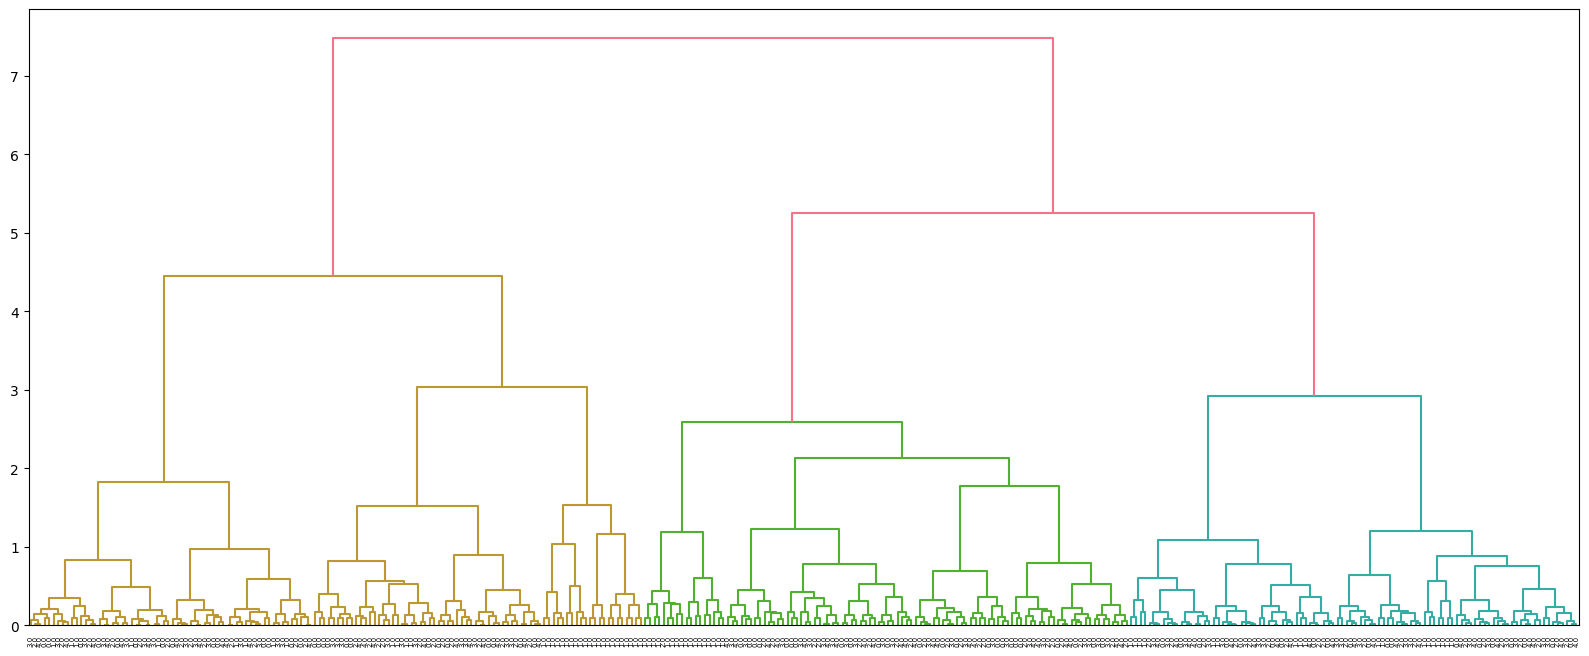

In [84]:
def plot_dendrogram(X, y):
    y_flat = y.values.flatten()
    samples = X.values
    mergings = linkage(samples, method='ward')

    plt.figure(figsize=(20, 8))
    dendrogram(mergings, labels=list(y_flat), leaf_rotation=90, leaf_font_size=5)
    plt.show()

plot_dendrogram(X, y)